In [ ]:
#object-oriented nn

In [1]:
import numpy as np

In [42]:
class Operation(object):
    """
    """

    def __init__(self):
        pass

    def forward(self, input_):
        #Almacena entrada y devuelve salida
        self.input_ = input_

        self.output = self._output()

        return self.output


    def backward(self, output_grad):
        #toma los gradientes de capas anteriores y devuelve
        #un nuevo gradiente junto a los anteriores

        self.input_grad = self._input_grad(output_grad) #almacena

        return self.input_grad


    def _output(self):
        #esto debe estar definido para cada operación
        raise NotImplementedError()


    def _input_grad(self, output_grad):
        #nuevamente, el gradiente para la capa actual está definido específicamente
        #para cada operación (tomará los gradientes de capas anteriores y multiplicará)
        raise NotImplementedError()
        



    

In [43]:
class ParamOperation(Operation):
    #hereda a Operation

    def __init__(self, param):
        #toma el parámetro al cual se opera una operación específica
        #ejemplo: toma X y realiza una clase WeightMultiply

        super().__init__() #inincializa clase padre
        self.param = param #almacenamos el parámetro



    def backward(self, output_grad):

        self.input_grad = self._input_grad(output_grad)
        #aplicará gradiente actual a los anteriores


        self.param_grad = self._param_grad(output_grad)

        return self.input_grad


    def _param_grad(self, output_grad):
        raise NotImplementedError()




        
    

In [44]:
#ahora, definamos una operación con parámetros específica, al multiplicar X por pesos

class WeightMultiply(ParamOperation):

    def __init__(self, W):

        super().__init__(W) #almacenamos el peso como parámetro en ParamOperation()
        #lo almacena

    def _output(self):
        
        return np.dot(self.input_, self.param)
        #la entrada actual, atributo que se guardará se aplica con el parámetro
        #(pesos)

    def _input_grad(self, output_grad):
        #
        return np.dot(output_grad, np.transpose(self.param, (1, 0)))

    def _param_grad(self, output_grad):
        #multiplica los gradientes anteriores (output_grad) con el gradiente actual

        #X*W -> su derivada en términos del param W es X (input_) traspuesta
        return np.dot(np.transpose(self.input_, (1, 0)), output_grad)



In [46]:
class BiasAdd(ParamOperation):
    #para la suma del bias

    def __init__(self,
                 B):        
        super().__init__(B) #se almacena el parámetro del bias (intercepto)

    def _output(self):
        #calculamos la salida sumando la entrada que nos llega más dicho parámetro
        
        return self.input_ + self.param

    def _input_grad(self, output_grad):
        #multiplicamos el gradiente actual (tantos unos como la entrada)
        #multplicado por los gradientes anteriores
        return np.ones_like(self.input_) * output_grad

    def _param_grad(self, output_grad):
        
        param_grad = np.ones_like(self.param) * output_grad
        return np.sum(param_grad, axis=0).reshape(1, param_grad.shape[1])

In [64]:
class Sigmoid(Operation):

    def __init__(self):
        super().__init__()

    def _output(self):
        #1/(1+e**-x)
        return 1.0/(1.0+np.exp(-1.0 * self.input_))

    def _input_grad(self, output_grad):
        #sigmoide tiene la propiedad de que se puede expresar su derivada
        #en términos de su misma salida
        sigmoid_backward = self.output * (1.0 - self.output)
        #multiplicamos el gradiente actual con los anteriores
        input_grad = sigmoid_backward * output_grad
        return input_grad

In [65]:
class Linear(Operation):
    #función identidad f(x) = x

    def __init__(self) -> None:     
        super().__init__()

    def _output(self):
        return self.input_

    def _input_grad(self, output_grad):
        return output_grad

In [66]:
class Layer(object):
    '''
    A "layer" of neurons in a neural network.
    '''

    def __init__(self,
                 neurons: int):
        
        self.neurons = neurons
        self.first = True
        self.params = [] #List[ndarray]
        self.param_grads = [] #List[ndarray]
        self.operations = [] # List[Operation]
        
    def _setup_layer(self, num_in: int) -> None:
        #la configuración de capa lo implementa específicamente cada capa
        raise NotImplementedError()

    def forward(self, input_):
        
        if self.first:
            self._setup_layer(input_)
            self.first = False

        self.input_ = input_

        for operation in self.operations:

            input_ = operation.forward(input_)

        self.output = input_

        return self.output

    def backward(self, output_grad):
        #pasa a través de una serie de Operations

        # assert_same_shape(self.output, output_grad)

        for operation in reversed(self.operations):
            #toma el primer gradiente output_grad y va actualizándole
            #conforme lo va multiplicando con los demás gradientes
            output_grad = operation.backward(output_grad)

        input_grad = output_grad
        
        self._param_grads()

        return input_grad

    def _param_grads(self):
        '''
        Extracts the _param_grads from a layer's operations
        '''

        self.param_grads = []
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.param_grads.append(operation.param_grad)


    def _params(self):
        #extrae los _params de una serie de Operations
        self.params = []
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.params.append(operation.param)

In [67]:
class Dense(Layer):
    #una capa fully-connected hereda de Layer
    def __init__(self,
                 neurons: int,
                 activation: Operation = Sigmoid()):
        #la capa requiere una activación antes de la inincialización
        super().__init__(neurons)
        self.activation = activation

    def _setup_layer(self, input_):
        #define las operaciones de la capa
        if self.seed:
            np.random.seed(self.seed)

        self.params = []

        #inincializa los pesos
        self.params.append(np.random.randn(input_.shape[1], self.neurons))

        # el bias
        self.params.append(np.random.randn(1, self.neurons))

        #las operaciones = activación(ponderación + bias)
        self.operations = [WeightMultiply(self.params[0]),
                           BiasAdd(self.params[1]),
                           self.activation]
        return None

In [68]:
class Loss(object):
    #pérdida de la red

    def __init__(self):
        pass

    def forward(self, prediction, target) -> float:
        #calcula la pérdida actual
        # assert_same_shape(prediction, target)

        self.prediction = prediction
        self.target = target

        loss_value = self._output() #calcula la salida usando _output() clases heredadas

        return loss_value

    def backward(self):
        #gradiente en términos de la función de pérdidas
        self.input_grad = self._input_grad()
        #llama a la función que calcula el gradiente(depende de la función de pérdidas)
        
        #assert_same_shape(self.prediction, self.input_grad)

        return self.input_grad

    def _output(self):
        #cada función de pérdidas da una salida distinta
        
        raise NotImplementedError()
        
    def _input_grad(self):
        #el gradiente depende de la función de pérdidas: MSE, BCE...etc
        raise NotImplementedError()
    

In [69]:
#definimos una función de pérdidas concreta: MSE

class MeanSquaredError(Loss):

    def __init__(self) -> None:
        super().__init__()

    def _output(self) -> float:
       
        loss = (
            np.sum(np.power(self.prediction - self.target, 2)) / 
            self.prediction.shape[0]
        )

        return loss

    def _input_grad(self):
        #gradiente del MSE  

        return 2.0 * (self.prediction - self.target) / self.prediction.shape[0]

In [70]:
class NeuralNetwork(object):
    '''
    The class for a neural network.
    '''
    def __init__(self, 
                 layers, #List[Layer]
                 loss: Loss,
                 seed: int = 1) -> None:
        '''
        Neural networks need layers, and a loss.
        '''
        self.layers = layers
        self.loss = loss
        self.seed = seed
        if seed:
            for layer in self.layers:
                setattr(layer, "seed", self.seed)        

    def forward(self, x_batch):
        '''
        Passes data forward through a series of layers.
        '''
        x_out = x_batch
        for layer in self.layers:
            x_out = layer.forward(x_out)

        return x_out

    def backward(self, loss_grad) -> None:
        '''
        Passes data backward through a series of layers.
        '''
        #pasamos los datos hacia atrás
        grad = loss_grad
        #inincialmente el gradiente comienza siendo el de la función de pérdidas
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
            #aplica gradiente inincial a los siguientes hacia atrás y sobreescribe

        return None

    def train_batch(self,
                    x_batch,
                    y_batch) -> float:
        '''
        Passes data forward through the layers.
        Computes the loss.
        Passes data backward through the layers.
        '''
        
        predictions = self.forward(x_batch)

        loss = self.loss.forward(predictions, y_batch)

        self.backward(self.loss.backward())

        return loss

    def params(self):
        '''
        Gets the parameters for the network.
        '''
        for layer in self.layers:
            yield from layer.params
            
    def param_grads(self):
        '''
        Gets the gradient of the loss with respect to the parameters for the network.
        '''
        for layer in self.layers:
            yield from layer.param_grads 
        #ob

In [71]:
class Optimizer(object):
    
    def __init__(self,
                 lr: float = 0.01):
        #guardamos el learning rate
        self.lr = lr

    def step(self) -> None:
        #obtiene los gradientes
        pass

In [72]:
class SGD(Optimizer):
   
    def __init__(self,
                 lr: float = 0.01) -> None:
        super().__init__(lr)

    def step(self):
     
        for (param, param_grad) in zip(self.net.params(),
                                       self.net.param_grads()):

            param -= self.lr * param_grad

In [73]:
from copy import deepcopy
from typing import Tuple

class Trainer(object):
    '''
    Trains a neural network
    '''
    def __init__(self,
                 net: NeuralNetwork,
                 optim: Optimizer) -> None:
        '''
        Requires a neural network and an optimizer in order for training to occur. 
        Assign the neural network as an instance variable to the optimizer.
        '''
        self.net = net
        self.optim = optim
        self.best_loss = 1e9
        setattr(self.optim, 'net', self.net)
        
    def generate_batches(self,
                         X,
                         y,
                         size: int = 32): #Tuple[ndarray]
        '''
        Generates batches for training 
        # '''
        # assert X.shape[0] == y.shape[0], \
        # '''
        # features and target must have the same number of rows, instead
        # features has {0} and target has {1}
        # '''.format(X.shape[0], y.shape[0])

        N = X.shape[0]

        for ii in range(0, N, size):
            X_batch, y_batch = X[ii:ii+size], y[ii:ii+size]

            yield X_batch, y_batch

            
    def fit(self, X_train, y_train,
            X_test, y_test,
            epochs: int=100,
            eval_every: int=10,
            batch_size: int=32,
            seed: int = 1,
            restart: bool = True)-> None:
        '''
        Fits the neural network on the training data for a certain number of epochs.
        Every "eval_every" epochs, it evaluated the neural network on the testing data.
        '''

        np.random.seed(seed)
        if restart:
            for layer in self.net.layers:
                layer.first = True

            self.best_loss = 1e9

        for e in range(epochs):

            if (e+1) % eval_every == 0:
                
                # for early stopping
                last_model = deepcopy(self.net)

            X_train, y_train = permute_data(X_train, y_train)

            batch_generator = self.generate_batches(X_train, y_train,
                                                    batch_size)

            for ii, (X_batch, y_batch) in enumerate(batch_generator):

                self.net.train_batch(X_batch, y_batch)

                self.optim.step()

            if (e+1) % eval_every == 0:

                test_preds = self.net.forward(X_test)
                loss = self.net.loss.forward(test_preds, y_test)
        
                if loss < self.best_loss:
                    print(f"Validation loss after {e+1} epochs is {loss:.3f}")
                    self.best_loss = loss
                else:
                    print(f"""Loss increased after epoch {e+1}, final loss was {self.best_loss:.3f}, using the model from epoch {e+1-eval_every}""")
                    self.net = last_model
                    # ensure self.optim is still updating self.net
                    setattr(self.optim, 'net', self.net)
                    break      

In [74]:
def mae(y_true, y_pred):
    '''
    Compute mean absolute error for a neural network.
    '''    
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    '''
    Compute root mean squared error for a neural network.
    '''
    return np.sqrt(np.mean(np.power(y_true - y_pred, 2)))

def eval_regression_model(model: NeuralNetwork,
                          X_test,
                          y_test):
    '''
    Compute mae and rmse for a neural network.
    '''
    preds = model.forward(X_test)
    preds = preds.reshape(-1, 1)
    print("Mean absolute error: {:.2f}".format(mae(preds, y_test)))
    print()
    print("Root mean squared error {:.2f}".format(rmse(preds, y_test)))

In [86]:
dl = NeuralNetwork(
    layers=[Dense(neurons=13,
                   activation=Sigmoid()),
            Dense(neurons=13,
                   activation=Sigmoid()),
            Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

In [87]:
dl

In [88]:
X = np.linspace(-10,10, 500).reshape(-1,1)
y = np.sin(X).reshape(-1,1)

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [90]:
# helper function

def permute_data(X, y):
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [95]:
trainer = Trainer(dl, SGD(lr=0.01))

trainer.fit(X_train, y_train, X_test, y_test,
       epochs = 150,
       eval_every = 10,
       seed=20190501);
print()
eval_regression_model(dl, X_test, y_test)

Validation loss after 10 epochs is 0.466
Validation loss after 20 epochs is 0.451
Validation loss after 30 epochs is 0.445
Validation loss after 40 epochs is 0.441
Validation loss after 50 epochs is 0.438
Validation loss after 60 epochs is 0.433
Validation loss after 70 epochs is 0.431
Validation loss after 80 epochs is 0.428
Validation loss after 90 epochs is 0.425
Validation loss after 100 epochs is 0.421
Validation loss after 110 epochs is 0.418
Validation loss after 120 epochs is 0.414
Validation loss after 130 epochs is 0.410
Validation loss after 140 epochs is 0.405
Validation loss after 150 epochs is 0.401

Mean absolute error: 0.55

Root mean squared error 0.63


In [96]:
import matplotlib.pyplot as plt

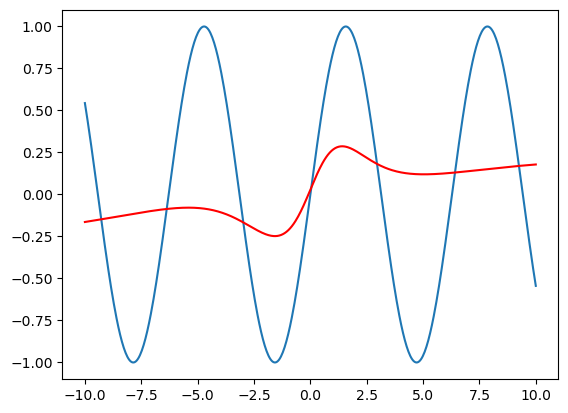

In [97]:
plt.plot(X, y)
plt.plot(X, dl.forward(X), color="red")